# Homework 3 Problem 1

In this homework, you'll learn how to model the sentences with recurrent neural networks(RNNs). We'll provide you with basic skeleton codes for preprocessing sequences and performing sentimental analysis with RNNs. However, provided codes can be improved with some simple modifications. The purpose of this homework is to implement several advanced techniques for improving the performance of vanilla RNNs.

First, we'll import required libraries.

In [23]:
!pip install torchtext
!pip install spacy
!python -m spacy download en
import random
import time

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext import data
from torchtext import datasets

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


## Preprocessing

For your convenience, we will provide you with the basic preprocessing steps for handling IMDB movie dataset. For more information, see https://pytorch.org/text/

In [0]:
TEXT = data.Field(tokenize='spacy', include_lengths=True)
LABEL = data.LabelField(dtype=torch.float)
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

In [25]:
train_data, valid_data = train_data.split(random_state=random.seed(1234))

print('Number of training examples: {:d}'.format(len(train_data)))
print('NUmber of validation examples: {:d}'.format(len(valid_data)))
print('Number of testing examples: {:d}'.format(len(test_data)))

Number of training examples: 17500
NUmber of validation examples: 7500
Number of testing examples: 25000


In [26]:
TEXT.build_vocab(train_data,
                 max_size=25000)
LABEL.build_vocab(train_data)
# Tokens include <unk> and <pad>
print('Unique tokens in text vocabulary: {:d}'.format(len(TEXT.vocab)))
# Label is either positive or negative
print('Unique tokens in label vocabulary: {:d}'.format(len(LABEL.vocab)))

Unique tokens in text vocabulary: 25002
Unique tokens in label vocabulary: 2


In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
batch_size = 64
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=batch_size,
    sort_within_batch=False,
    device=device)

In [28]:
print(device)

cuda:0


In [29]:
# Note that the sequence is padded with <PAD>(=1) tokens after the sequence ends.
for batch in train_iterator:
    text, text_length = batch.text
    break

print(text[:, -1])
print(text[-10:, -1])
print(text_length[-1])

tensor([3842,   14,  870,  ...,    1,    1,    1], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor(147, device='cuda:0')


In [0]:
# We will re-load dataset since we already loaded one batch in above cell.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
batch_size = 64
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=batch_size,
    sort_within_batch=True,
    device=device)

# Problems

We will provide you with skeleton codes for training RNNs below. Run this code and you'll notice that the training / validation performance is not better than random guessing (50\~60%).
In this homework, you'll have to improve the performance of this network above 80% with several techniques commonly used in RNNs. **Please provide your answer in your report and attach notebook file which contains source code for below techniques.**

(a) (3pt) Look at the shape of tensor `hidden` and `embedded`. Have you noticed what is the problem? Explain what is the issue and report the test performance when you fix the issue. (Hint: This is related to the length of sequences. See how sequence is padded. You may use `nn.utils.rnn.pack_padded_sequence`.)

(b) (3pt) Use different architectures, such as LSTM or GRU, and report the test performance. "Do not" change hyperparameters from (a), such as batch_size, hidden_dim,...

Now, try to use below techniques to further improve the performance of provided source codes. Compare the test performance of each component with/without it.

(c) (1pt) For now, the number of layers in RNN is 1. Try to stack more layers, up to 3.

(d) (1pt) Use bidirectional RNNs.

(e) (1pt) Use dropout for regularization with stacked layers (recommended: 3 layers and dropout rate 0.5).

(f) (1pt) Finally, apply all techniques and have an enough time to play with introduced techniques (e.g., changing hyperparameters, train more epochs, try other techniques you know, ...). Report the final test performance with your implementation and hyperparameter choice. Please note that this is not a competition assignment. We will not evaluate your assignment strictly!

## Simple RNN architecture

In [0]:
class SimpleRNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(SimpleRNN, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.RNN(embedding_dim,
                           hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        output, hidden = self.rnn(embedded)
        hidden = hidden[-1]
        return self.fc(hidden.squeeze(0))

## Simple fixed RNN architecture

In [0]:
class FixedSimpleRNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(FixedSimpleRNN, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, text_lengths):
        # text.shape [padded_sentence_size, batch_size] 
        embedded = self.embedding(text)             # embedded.shape [padded_sentence_size, batch_size, embedding_dim]
        packed_seq = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, enforce_sorted=False)
        output, hidden = self.rnn(packed_seq)       # hidden.shape [num_layers * num_directions, batch_size, hidden_size], num_layers * num_directions = 1
        return self.fc(hidden.squeeze(0))           # hidden.squeeze(0) [batch_size, hidden_size]

## LSTM RNN architecture

In [0]:
class LSTMRNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(LSTMRNN, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_seq = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, enforce_sorted=False)
        output, (hn, cn) = self.lstm(packed_seq)
        return self.fc(hn.squeeze(0))

## GRU RNN architecture

In [0]:
class GRURNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(GRURNN, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_idx)
        self.gru = nn.GRU(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)    #[sentect len,batch size,embedding dim]
        packed_seq = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, enforce_sorted=False)
        output, hidden = self.gru(packed_seq)
        return self.fc(hidden.squeeze(0))

## Stacked layers and Dropout RNN architecture

In [0]:
class StackedRNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, pad_idx, num_layers=1, dropout=0):
        if num_layers<=0:
            raise Exception('num_layers must be major than 0')
        super(StackedRNN, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_seq = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, enforce_sorted=False)
        output, hidden = self.rnn(packed_seq)
        hidden = hidden[-1]
        return self.fc(hidden)

## Bidirectional RNN architecture

In [0]:
class BidirectionalRNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(BidirectionalRNN, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_seq = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, enforce_sorted=False)
        output, hidden = self.rnn(packed_seq)
        conc_hidden = torch.cat((hidden[0], hidden[1]), 1)
        return self.fc(conc_hidden)

## Custom RNN architecture

In [0]:
class CustomRNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(CustomRNN, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_idx)
        self.gru = nn.GRU(embedding_dim, hidden_dim, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)    #[sentect len,batch size,embedding dim]
        packed_seq = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, enforce_sorted=False)
        output, hn = self.gru(packed_seq)
        conc_hidden = torch.cat([hn[0], hn[1]], 1)
        return self.fc(conc_hidden)

# Train

In [0]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [0]:
input_dim = len(TEXT.vocab)
embedding_dim = 100 
hidden_dim = 128
output_dim = 1
num_epochs = 10
val_iter = 1
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]


In [0]:
def train(model, pth_path, input_dim = input_dim, embedding_dim = embedding_dim, hidden_dim = hidden_dim, output_dim = output_dim, num_epochs = num_epochs, val_iter = val_iter, pad_idx = pad_idx, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss().to(device)
    model = model.to(device)
    model.train()
    train_loss = list()
    train_acc = list()
    val_loss = list()
    val_acc = list()
    best_valid_loss = float('inf')
    for epoch in range(num_epochs):
        running_loss = 0
        running_acc = 0

        start_time = time.time()
        
        for batch in train_iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(-1)
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_acc += acc.item()
            
        running_loss /= len(train_iterator)
        running_acc /= len(train_iterator)
        train_loss.append(running_loss)
        train_acc.append(running_acc)
        
        if epoch % val_iter == 0:
            model.eval()
            valid_loss = 0
            valid_acc = 0
            
            with torch.no_grad():
                for batch in valid_iterator:
                    text, text_lengths = batch.text
                    eval_predictions = model(text, text_lengths).squeeze(1)
                    valid_loss += criterion(eval_predictions, batch.label).item()
                    valid_acc += binary_accuracy(eval_predictions, batch.label).item()
                    
            model.train()
            valid_loss /= len(valid_iterator)
            valid_acc /= len(valid_iterator)
            val_loss.append(valid_loss)
            val_acc.append(valid_acc)
            
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(model.state_dict(), pth_path)  
            
        training_time = time.time() - start_time
        print('#####################################')
        print('Epoch {:d} | Training Time {:.1f}s'.format(epoch+1, training_time))
        print('Train Loss: {:.4f}, Train Acc: {:.2f}%'.format(running_loss, running_acc*100))
        if epoch % val_iter == 0:
            print('Valid Loss: {:.4f}, Valid Acc: {:.2f}%'.format(valid_loss, valid_acc*100))
    return train_loss, train_acc, val_loss, val_acc


In [0]:
def load_model_test_performance(model, model_path):
    model.load_state_dict(torch.load(model_path))
    criterion = nn.BCEWithLogitsLoss().to(device)
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.no_grad():
        for batch in test_iterator:
            text, text_lengths = batch.text
            test_preds = model(text, text_lengths).squeeze(1)
            test_loss += criterion(test_preds, batch.label).item()
            test_acc += binary_accuracy(test_preds, batch.label).item()
        test_loss /= len(test_iterator)
        test_acc /= len(test_iterator)
    print('Test Loss: {:.4f}, Test Acc: {:.2f}%'.format(test_loss, test_acc*100))

In [0]:
def plot(train_loss, train_acc, val_loss, val_acc):
    plt.figure(figsize=(10, 5))
    plt.title("Training plot")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid()
    plt.plot(range(1, len(train_loss)+1), train_loss, label="training loss")
    plt.plot(range(1, len(train_acc)+1), train_acc, label="training accuracy")
    plt.plot(range(1, len(val_loss)+1), val_loss, label="validation loss")
    plt.plot(range(1, len(val_acc)+1), val_acc, label="validation accuracy")
    plt.legend()
    plt.show()

#####################################
Epoch 1 | Training Time 17.5s
Train Loss: 0.6940, Train Acc: 52.04%
Valid Loss: 0.6930, Valid Acc: 51.67%
#####################################
Epoch 2 | Training Time 16.4s
Train Loss: 0.6907, Train Acc: 52.86%
Valid Loss: 0.6677, Valid Acc: 60.25%
#####################################
Epoch 3 | Training Time 15.5s
Train Loss: 0.6760, Train Acc: 57.49%
Valid Loss: 0.6766, Valid Acc: 58.21%
#####################################
Epoch 4 | Training Time 15.6s
Train Loss: 0.6790, Train Acc: 55.27%
Valid Loss: 0.6924, Valid Acc: 51.36%
#####################################
Epoch 5 | Training Time 16.5s
Train Loss: 0.6945, Train Acc: 50.31%
Valid Loss: 0.6952, Valid Acc: 48.87%
#####################################
Epoch 6 | Training Time 15.2s
Train Loss: 0.6946, Train Acc: 50.76%
Valid Loss: 0.6940, Valid Acc: 48.98%
#####################################
Epoch 7 | Training Time 15.3s
Train Loss: 0.6937, Train Acc: 51.42%
Valid Loss: 0.6993, Valid Acc:

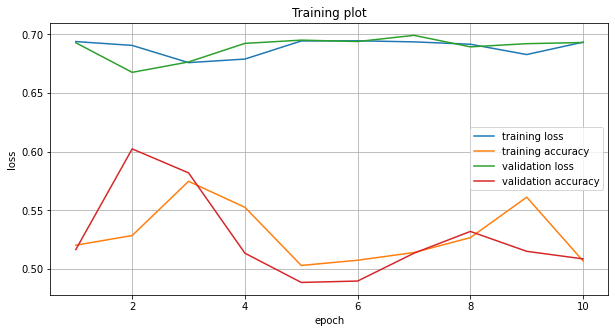

Test Loss: 0.6612, Test Acc: 61.03%


In [45]:
model = SimpleRNN(input_dim, embedding_dim, hidden_dim, output_dim, pad_idx)
train_loss, train_acc, val_loss, val_acc = train(model, './simplernn.pth')
plot(train_loss, train_acc, val_loss, val_acc)
load_model_test_performance(model, './simplernn.pth')

#####################################
Epoch 1 | Training Time 19.3s
Train Loss: 0.6902, Train Acc: 53.38%
Valid Loss: 0.6797, Valid Acc: 56.32%
#####################################
Epoch 2 | Training Time 19.2s
Train Loss: 0.6591, Train Acc: 59.79%
Valid Loss: 0.6566, Valid Acc: 59.69%
#####################################
Epoch 3 | Training Time 18.7s
Train Loss: 0.6352, Train Acc: 63.35%
Valid Loss: 0.6648, Valid Acc: 58.46%
#####################################
Epoch 4 | Training Time 18.9s
Train Loss: 0.6159, Train Acc: 65.29%
Valid Loss: 0.6580, Valid Acc: 59.50%
#####################################
Epoch 5 | Training Time 19.2s
Train Loss: 0.5551, Train Acc: 71.50%
Valid Loss: 0.6054, Valid Acc: 68.44%
#####################################
Epoch 6 | Training Time 18.6s
Train Loss: 0.4971, Train Acc: 76.08%
Valid Loss: 0.6211, Valid Acc: 68.16%
#####################################
Epoch 7 | Training Time 18.5s
Train Loss: 0.4759, Train Acc: 77.45%
Valid Loss: 0.6278, Valid Acc:

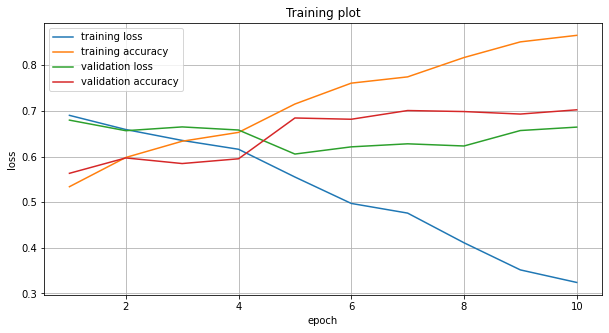

Test Loss: 0.6011, Test Acc: 68.82%


In [46]:
model = FixedSimpleRNN(input_dim, embedding_dim, hidden_dim, output_dim, pad_idx)
train_loss, train_acc, val_loss, val_acc = train(model, './fixedsimplernn.pth')
plot(train_loss, train_acc, val_loss, val_acc)
load_model_test_performance(model, './fixedsimplernn.pth')

#####################################
Epoch 1 | Training Time 18.3s
Train Loss: 0.6486, Train Acc: 61.95%
Valid Loss: 0.6064, Valid Acc: 67.61%
#####################################
Epoch 2 | Training Time 17.7s
Train Loss: 0.5875, Train Acc: 70.12%
Valid Loss: 0.5792, Valid Acc: 72.42%
#####################################
Epoch 3 | Training Time 18.1s
Train Loss: 0.5343, Train Acc: 73.35%
Valid Loss: 0.5265, Valid Acc: 76.73%
#####################################
Epoch 4 | Training Time 17.6s
Train Loss: 0.4948, Train Acc: 77.83%
Valid Loss: 0.4922, Valid Acc: 77.22%
#####################################
Epoch 5 | Training Time 17.9s
Train Loss: 0.3872, Train Acc: 83.65%
Valid Loss: 0.4523, Valid Acc: 80.29%
#####################################
Epoch 6 | Training Time 17.8s
Train Loss: 0.3380, Train Acc: 85.67%
Valid Loss: 0.5784, Valid Acc: 68.65%
#####################################
Epoch 7 | Training Time 17.9s
Train Loss: 0.3539, Train Acc: 84.78%
Valid Loss: 0.4392, Valid Acc:

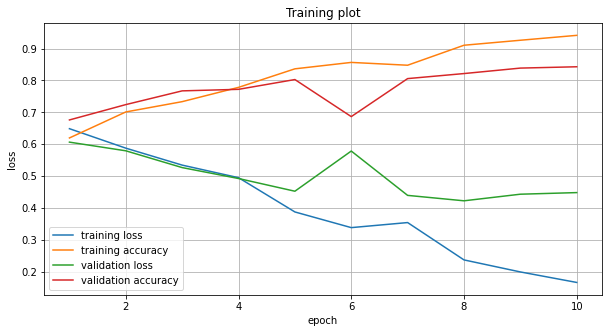

Test Loss: 0.4349, Test Acc: 81.56%


In [47]:
model = LSTMRNN(input_dim, embedding_dim, hidden_dim, output_dim, pad_idx)
train_loss, train_acc, val_loss, val_acc = train(model, './lstmrnn.pth')
plot(train_loss, train_acc, val_loss, val_acc)
load_model_test_performance(model, './lstmrnn.pth')

#####################################
Epoch 1 | Training Time 17.4s
Train Loss: 0.6590, Train Acc: 60.02%
Valid Loss: 0.6794, Valid Acc: 56.29%
#####################################
Epoch 2 | Training Time 16.7s
Train Loss: 0.5982, Train Acc: 67.41%
Valid Loss: 0.5542, Valid Acc: 71.90%
#####################################
Epoch 3 | Training Time 16.7s
Train Loss: 0.4348, Train Acc: 80.66%
Valid Loss: 0.4538, Valid Acc: 78.84%
#####################################
Epoch 4 | Training Time 16.7s
Train Loss: 0.3161, Train Acc: 87.07%
Valid Loss: 0.3723, Valid Acc: 83.84%
#####################################
Epoch 5 | Training Time 16.8s
Train Loss: 0.2308, Train Acc: 91.27%
Valid Loss: 0.3477, Valid Acc: 85.73%
#####################################
Epoch 6 | Training Time 16.7s
Train Loss: 0.1585, Train Acc: 94.26%
Valid Loss: 0.3580, Valid Acc: 86.58%
#####################################
Epoch 7 | Training Time 16.7s
Train Loss: 0.1004, Train Acc: 96.67%
Valid Loss: 0.3788, Valid Acc:

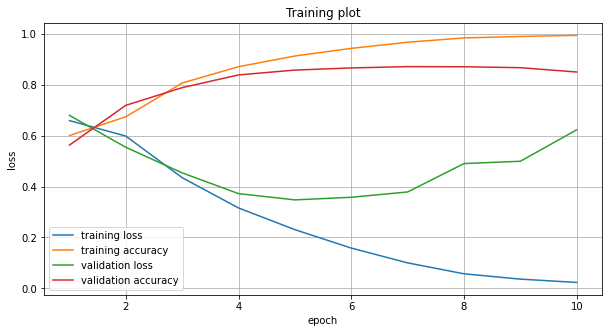

Test Loss: 0.3433, Test Acc: 85.90%


In [48]:
model = GRURNN(input_dim, embedding_dim, hidden_dim, output_dim, pad_idx)
train_loss, train_acc, val_loss, val_acc = train(model, './grurnn.pth')
plot(train_loss, train_acc, val_loss, val_acc)
load_model_test_performance(model, './grurnn.pth')

#####################################
Epoch 1 | Training Time 24.0s
Train Loss: 0.6862, Train Acc: 54.58%
Valid Loss: 0.6779, Valid Acc: 57.38%
#####################################
Epoch 2 | Training Time 23.8s
Train Loss: 0.6499, Train Acc: 61.80%
Valid Loss: 0.7022, Valid Acc: 55.19%
#####################################
Epoch 3 | Training Time 23.9s
Train Loss: 0.6331, Train Acc: 64.18%
Valid Loss: 0.6371, Valid Acc: 63.84%
#####################################
Epoch 4 | Training Time 23.9s
Train Loss: 0.5591, Train Acc: 71.79%
Valid Loss: 0.6011, Valid Acc: 69.25%
#####################################
Epoch 5 | Training Time 23.9s
Train Loss: 0.5508, Train Acc: 72.48%
Valid Loss: 0.5686, Valid Acc: 72.60%
#####################################
Epoch 6 | Training Time 23.9s
Train Loss: 0.4645, Train Acc: 78.98%
Valid Loss: 0.5856, Valid Acc: 71.46%
#####################################
Epoch 7 | Training Time 23.8s
Train Loss: 0.4044, Train Acc: 83.00%
Valid Loss: 0.5447, Valid Acc:

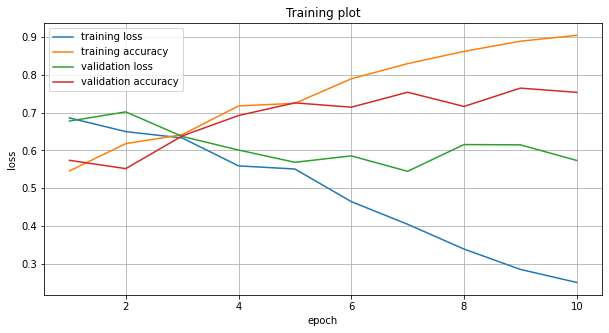

Test Loss: 0.5558, Test Acc: 75.02%


In [54]:
model = StackedRNN(input_dim, embedding_dim, hidden_dim, output_dim, pad_idx, num_layers=3)
train_loss, train_acc, val_loss, val_acc = train(model, './stackedrnn.pth')
plot(train_loss, train_acc, val_loss, val_acc)
load_model_test_performance(model, './stackedrnn.pth')

#####################################
Epoch 1 | Training Time 19.9s
Train Loss: 0.6849, Train Acc: 55.76%
Valid Loss: 0.6670, Valid Acc: 59.96%
#####################################
Epoch 2 | Training Time 18.9s
Train Loss: 0.6308, Train Acc: 64.26%
Valid Loss: 0.6337, Valid Acc: 64.34%
#####################################
Epoch 3 | Training Time 19.0s
Train Loss: 0.5959, Train Acc: 67.73%
Valid Loss: 0.6085, Valid Acc: 67.73%
#####################################
Epoch 4 | Training Time 19.0s
Train Loss: 0.5771, Train Acc: 69.24%
Valid Loss: 0.6347, Valid Acc: 63.99%
#####################################
Epoch 5 | Training Time 19.0s
Train Loss: 0.4972, Train Acc: 75.64%
Valid Loss: 0.6109, Valid Acc: 67.71%
#####################################
Epoch 6 | Training Time 19.2s
Train Loss: 0.4044, Train Acc: 81.59%
Valid Loss: 0.5829, Valid Acc: 71.76%
#####################################
Epoch 7 | Training Time 18.9s
Train Loss: 0.3555, Train Acc: 84.25%
Valid Loss: 0.6065, Valid Acc:

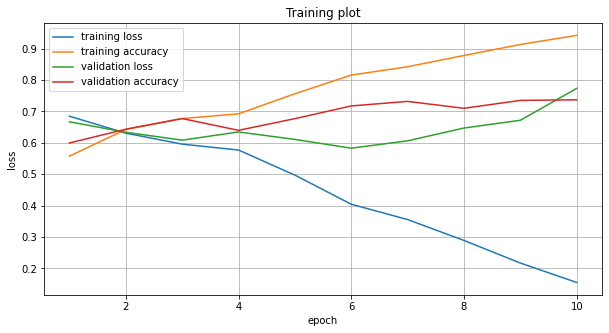

Test Loss: 0.6041, Test Acc: 70.54%


In [55]:
model = BidirectionalRNN(input_dim, embedding_dim, hidden_dim, output_dim, pad_idx)
train_loss, train_acc, val_loss, val_acc = train(model, './birnn.pth')
plot(train_loss, train_acc, val_loss, val_acc)
load_model_test_performance(model, './birnn.pth')

#####################################
Epoch 1 | Training Time 65.4s
Train Loss: 0.6865, Train Acc: 55.40%
Valid Loss: 0.6918, Valid Acc: 52.20%
#####################################
Epoch 2 | Training Time 63.7s
Train Loss: 0.6944, Train Acc: 51.38%
Valid Loss: 0.6909, Valid Acc: 51.82%
#####################################
Epoch 3 | Training Time 63.6s
Train Loss: 0.6866, Train Acc: 54.71%
Valid Loss: 0.6815, Valid Acc: 55.57%
#####################################
Epoch 4 | Training Time 63.8s
Train Loss: 0.6648, Train Acc: 60.11%
Valid Loss: 0.6564, Valid Acc: 61.37%
#####################################
Epoch 5 | Training Time 63.7s
Train Loss: 0.6222, Train Acc: 65.70%
Valid Loss: 0.6790, Valid Acc: 61.39%
#####################################
Epoch 6 | Training Time 63.8s
Train Loss: 0.5713, Train Acc: 71.30%
Valid Loss: 0.6366, Valid Acc: 65.40%
#####################################
Epoch 7 | Training Time 63.8s
Train Loss: 0.5248, Train Acc: 74.83%
Valid Loss: 0.6509, Valid Acc:

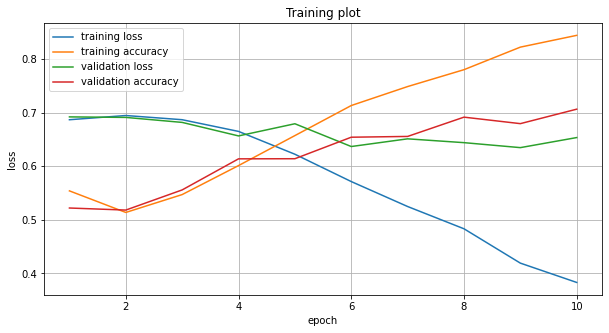

Test Loss: 0.6486, Test Acc: 67.01%


In [56]:
model = StackedRNN(input_dim, embedding_dim, hidden_dim, output_dim, pad_idx, num_layers=3, dropout=0.5)
train_loss, train_acc, val_loss, val_acc = train(model, './droprnn.pth')
plot(train_loss, train_acc, val_loss, val_acc)
load_model_test_performance(model, './droprnn.pth')

#####################################
Epoch 1 | Training Time 23.0s
Train Loss: 0.6328, Train Acc: 62.62%
Valid Loss: 0.5320, Valid Acc: 73.54%
#####################################
Epoch 2 | Training Time 23.0s
Train Loss: 0.4859, Train Acc: 76.45%
Valid Loss: 0.4646, Valid Acc: 77.77%
#####################################
Epoch 3 | Training Time 22.8s
Train Loss: 0.3996, Train Acc: 82.08%
Valid Loss: 0.4029, Valid Acc: 82.12%
#####################################
Epoch 4 | Training Time 22.9s
Train Loss: 0.3056, Train Acc: 86.95%
Valid Loss: 0.4008, Valid Acc: 82.10%
#####################################
Epoch 5 | Training Time 22.9s
Train Loss: 0.2433, Train Acc: 90.11%
Valid Loss: 0.4393, Valid Acc: 81.55%
#####################################
Epoch 6 | Training Time 22.8s
Train Loss: 0.1941, Train Acc: 92.38%
Valid Loss: 0.3832, Valid Acc: 84.43%
#####################################
Epoch 7 | Training Time 23.0s
Train Loss: 0.1456, Train Acc: 94.64%
Valid Loss: 0.3815, Valid Acc:

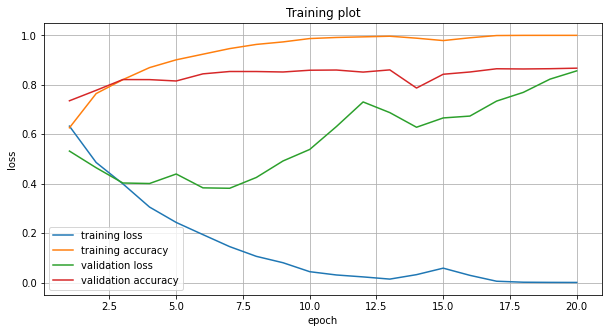

Test Loss: 0.3928, Test Acc: 84.64%


In [69]:
model = CustomRNN(input_dim, embedding_dim, hidden_dim, output_dim, pad_idx)
train_loss, train_acc, val_loss, val_acc = train(model, './customrnn.pth', hidden_dim = 256, num_epochs = 20, lr=0.0005)
plot(train_loss, train_acc, val_loss, val_acc)
load_model_test_performance(model, './customrnn.pth')